<a href="https://colab.research.google.com/github/erlonL/series-temporais/blob/main/decomposition_initial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import pickle
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import warnings
import statsmodels.api as sm
from IPython.display import clear_output
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Filtra todos os avisos do LightGBM
warnings.filterwarnings("ignore", category=UserWarning, message=".*lightgbm.*")

# Tratamento Inicial do DataFrame

In [2]:
with open('database/df.pkl', 'rb') as f:
    df = pickle.load(f)

df.head()

,item_nbr,year,month,onpromotion_anytime_in_month,unit_sales,year_month,family,class,perishable
0,103520,2013,1,True,201.00,2013-1,GROCERY I,1028,0
1,103520,2013,2,True,179.00,2013-2,GROCERY I,1028,0
2,103520,2013,3,True,296.00,2013-3,GROCERY I,1028,0
3,103520,2013,4,True,212.00,2013-4,GROCERY I,1028,0
4,103520,2013,5,True,172.00,2013-5,GROCERY I,1028,0


In [3]:
# logic that removes a item_nbr if it doesn't have all the months the other rows have

all_y_months = df['year_month'].unique()

for item_nbr in df['item_nbr'].unique():
    if len(df[df['item_nbr'] == item_nbr]['year_month'].unique()) != len(all_y_months):
        df = df[df['item_nbr'] != item_nbr]

len(df['item_nbr'].unique())

1025

In [4]:
df = df[df['unit_sales'] >= 0]

In [5]:
df.rename(columns={'year_month': 'date'}, inplace=True)
df['date'] = pd.to_datetime(df['date'])

#df.set_index('date', inplace=True)

# Decomposição

In [6]:
def plot_series(original, trend, seasonal, resid):
    fig, ax = plt.subplots(4, 1, figsize=(15, 10))
    original.plot(ax=ax[0])
    ax[0].set_title('Original')
    trend.plot(ax=ax[1])
    ax[1].set_title('Trend')
    seasonal.plot(ax=ax[2])
    ax[2].set_title('Seasonal')
    resid.plot(ax=ax[3])
    ax[3].set_title('Residual')
    plt.tight_layout()

    plt.show()

In [7]:
def decompose_series(series, period=12, plot=False):
    decomposition = seasonal_decompose(series, period=period)
    if plot:
        plot_series(series, decomposition.trend, decomposition.seasonal, decomposition.resid)
    return decomposition

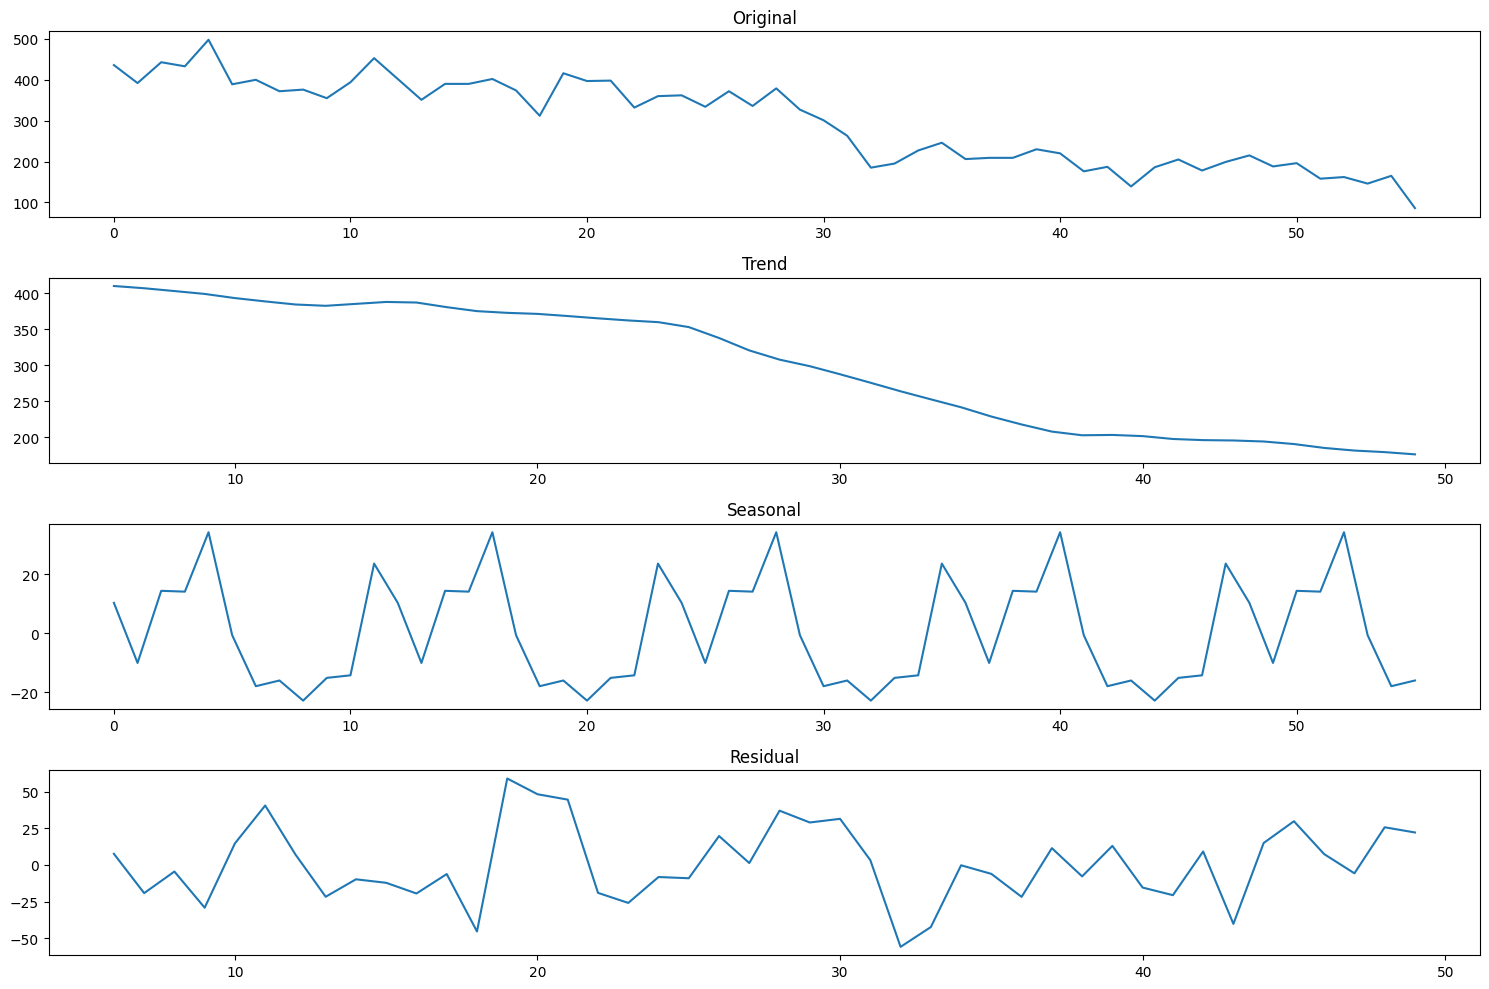

In [8]:
# decompor a série temporal em 3 componentes: tendência, sazonalidade e resíduosfrom statsmodels.tsa.seasonal import seasonal_decompose

item_nbr = 870938 # produto classe: DAIRY, perishable: True
df_item = df[df['item_nbr'] == item_nbr]
df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
decompose_series(df_item['unit_sales'], period=12, plot=True)

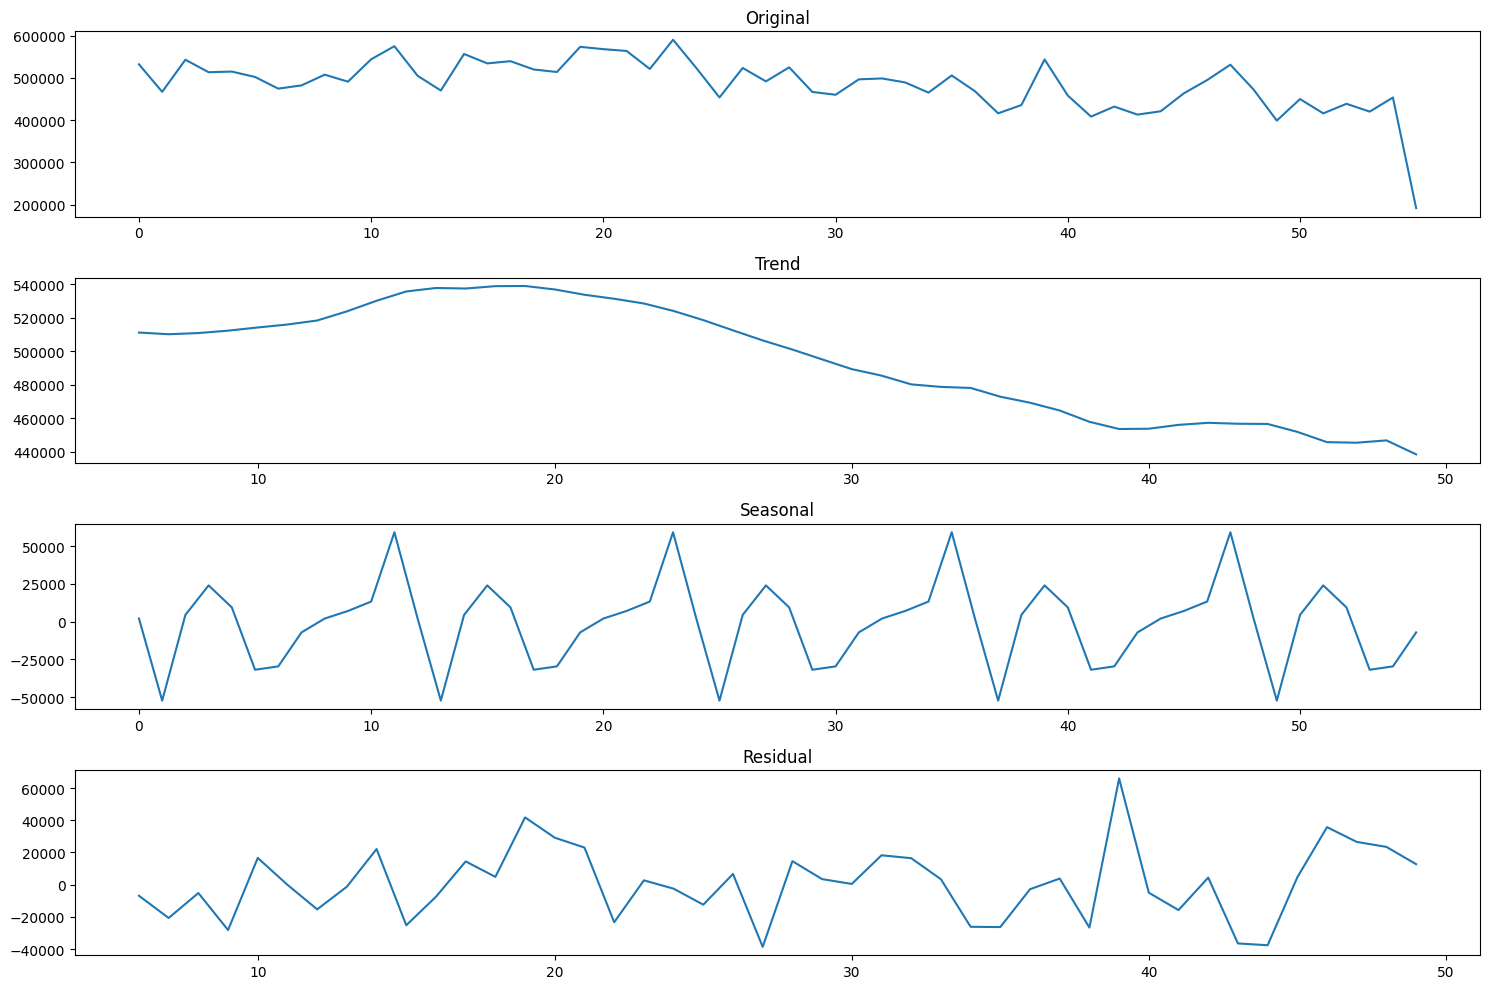

In [9]:
# série temporal da venda de todos os produtos
df_agg = df.groupby('date')['unit_sales'].sum().reset_index()

og_residual = decompose_series(df_agg['unit_sales'], period=12).resid
og_seasonal = decompose_series(df_agg['unit_sales'], period=12).seasonal
decompose_series(df_agg['unit_sales'], period=12, plot=True)

In [10]:
item_nbr = 870938 # produto classe: DAIRY, perishable: True
df_item = df[df['item_nbr'] == item_nbr]
df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()

ts = pd.Series(df_item['unit_sales'])

# Executar o teste de Dickey-Fuller Aumentado
result = adfuller(ts)

# Resultados do teste
print('Estatística do teste ADF:', result[0])
print('Valor-p:', result[1])

# Interpretação do resultado
if result[1] <= 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")


Estatística do teste ADF: -0.40596713982446847
Valor-p: 0.9090977012220002
A série temporal não é estacionária


# Testando a autocorrelação dos dados

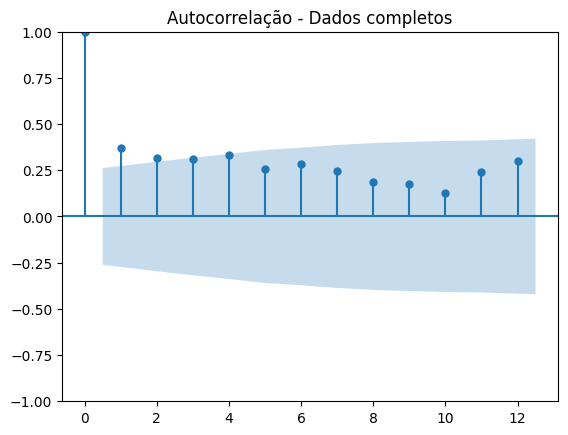

In [11]:
# Calcular a autocorrelação para as vendas dos dados agrupados

df_agg = df.groupby('date')['unit_sales'].sum().reset_index()

df_agg = df_agg.reset_index(drop=True)
#df_agg = df_agg.set_index('date') # can cause problems

#acf_values = sm.tsa.acf(df_agg['unit_sales'].values, nlags=12)

# Plotar a função de autocorrelação
sm.graphics.tsa.plot_acf(df_agg['unit_sales'].values, lags=12)
plt.title("Autocorrelação - Dados completos")
plt.show()

## Teste de hipótese para o produto aleatório escolhido

| O teste de Ljung-Box é usado comumente usado na modelagem  
do modelo ARIMA. Feito para testar autocorrelação dos dados  
podemos passar vários lags para testar qual dará como resultado  
uma correlação, ou não.

In [12]:
# teste
df_item = df[df['item_nbr'] == 870938]

values = df_item['unit_sales'].values

lags = range(1, 13)
# Realiza o teste Ljung-Box
df_test = acorr_ljungbox(values, lags=lags)
stat, p_value = (df_test['lb_stat'], df_test['lb_pvalue'])

for lag, p_val in zip(lags, p_value):
    if p_val < 0.05:
        print(f'Autocorrelação significativa encontrada no lag {lag} com p-valor {p_val}')

Autocorrelação significativa encontrada no lag 1 com p-valor 2.3697096687508174e-11
Autocorrelação significativa encontrada no lag 2 com p-valor 2.438690036328668e-19
Autocorrelação significativa encontrada no lag 3 com p-valor 5.315694828940524e-26
Autocorrelação significativa encontrada no lag 4 com p-valor 3.506149564623262e-32
Autocorrelação significativa encontrada no lag 5 com p-valor 2.878401811324229e-37
Autocorrelação significativa encontrada no lag 6 com p-valor 1.126331641783141e-41
Autocorrelação significativa encontrada no lag 7 com p-valor 9.520096738409975e-46
Autocorrelação significativa encontrada no lag 8 com p-valor 1.3013546529899781e-49
Autocorrelação significativa encontrada no lag 9 com p-valor 3.365970321095958e-53
Autocorrelação significativa encontrada no lag 10 com p-valor 3.9799435418056307e-56
Autocorrelação significativa encontrada no lag 11 com p-valor 1.7700498101968255e-58
Autocorrelação significativa encontrada no lag 12 com p-valor 3.9759029964033797e

Valores da ACF para diferentes lags:
[1.         0.86941817 0.82639294 0.75611708 0.72479321 0.6594629
 0.61413035 0.58786836 0.56897913 0.54575401 0.49704315 0.45120233
 0.39168532]


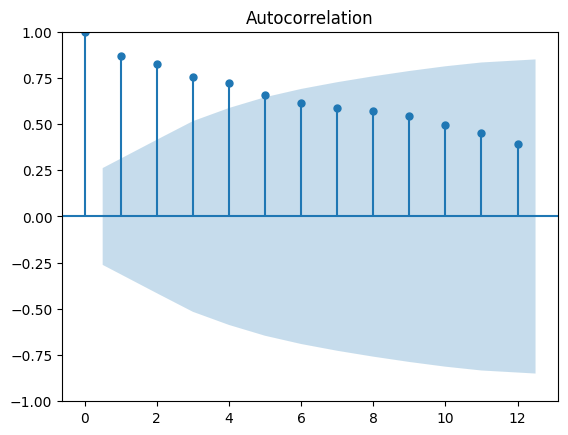

In [13]:
# Calcular a função de autocorrelação
acf_values = sm.tsa.acf(df_item['unit_sales'].values, nlags=12)
print("Valores da ACF para diferentes lags:")
print(acf_values)

# Plotar a função de autocorrelação
sm.graphics.tsa.plot_acf(df_item['unit_sales'].values, lags=12)
plt.show()

## Testando o restante dos itens do dataset

Valores da ACF para diferentes lags para o item 452212:
[1.         0.87742232 0.84861486 0.80656645 0.75918961 0.71325383
 0.68561888 0.60685263 0.56421199 0.51348354 0.45395813 0.38351306
 0.33619385]


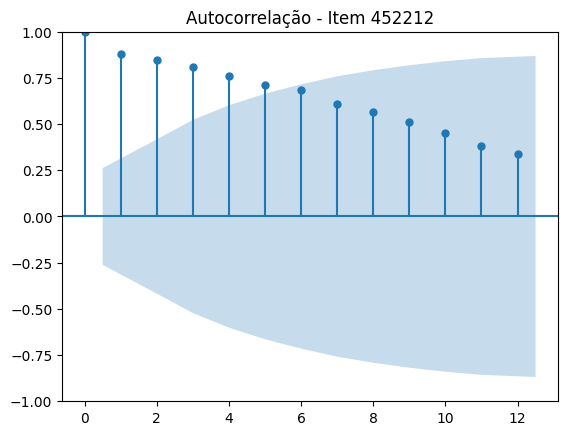

Valores da ACF para diferentes lags para o item 517905:
[1.         0.86783086 0.86121839 0.81353657 0.80056492 0.73927747
 0.70431579 0.60947085 0.58621216 0.53593391 0.47066188 0.40296768
 0.3666597 ]


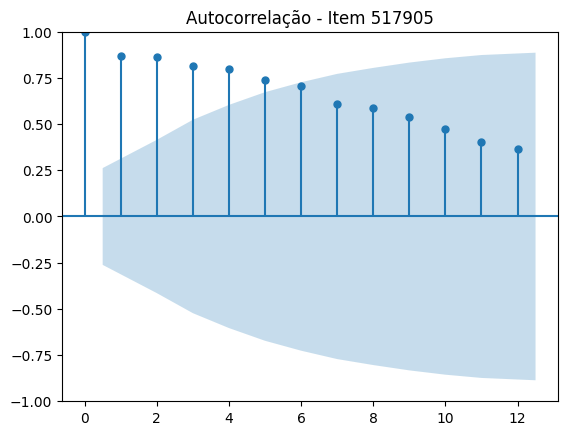

Valores da ACF para diferentes lags para o item 563966:
[1.         0.85084364 0.80844514 0.75148152 0.74748117 0.67139985
 0.63970227 0.59816863 0.57716338 0.53769103 0.47055393 0.4095389
 0.37254889]


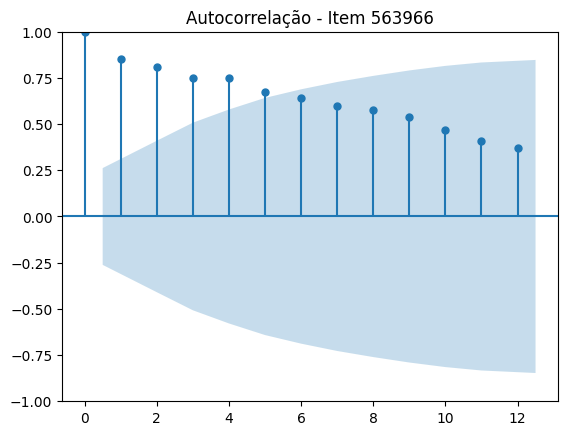

Valores da ACF para diferentes lags para o item 870938:
[1.         0.86941817 0.82639294 0.75611708 0.72479321 0.6594629
 0.61413035 0.58786836 0.56897913 0.54575401 0.49704315 0.45120233
 0.39168532]


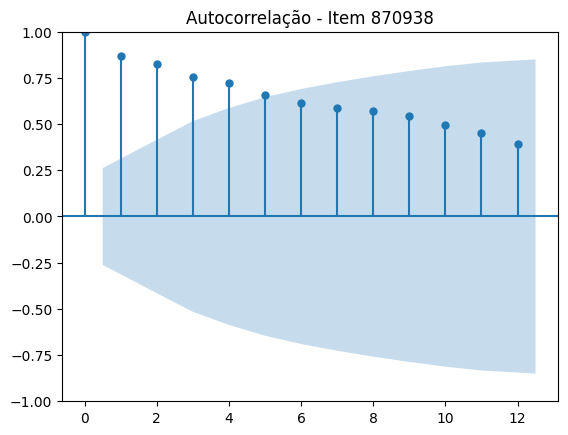

In [14]:
for item in df['item_nbr'].unique():
  df_item = df[df['item_nbr'] == item]
  df_item = df_item.groupby('date')['unit_sales'].sum().reset_index()
  df_item.reset_index(drop=True, inplace=True)
  df_item.drop(columns='date', inplace=True)
  acf_values = sm.tsa.acf(df_item, nlags=12)
  acf_mean = acf_values.sum() / 12
  if acf_mean > 0.7:
    print(f"Valores da ACF para diferentes lags para o item {item}:")
    print(acf_values)
    sm.graphics.tsa.plot_acf(df_item, lags=12)
    plt.title(f"Autocorrelação - Item {item}")
    plt.show()

# Avaliando residuais

Pressupostos para previsão

*   Não devem estar autocorrelacionados
*   Média deve ser zero (aproximadamente)
*   Variância constante
*   Distribuição normal

In [15]:
item_nbr = 870938 # produto classe: DAIRY, perishable: True
df_item = df[df['item_nbr'] == item_nbr]

decomposition = seasonal_decompose(df_item['unit_sales'], period=12)
residuos_item = decomposition.resid
residuos_item.isna().sum() # preencher os valores nulos com a média dos valores não nulos                           # ou droppar

12

Devido aos valores nan, não consegui verificar a autocorrelação dos residuos. Será necessário tratar os dados de alguma forma (dropar ou trocar por outro valor).

In [16]:
residuos_item.dropna(inplace=True) # decidimos droppar

In [17]:
residuos_item.mean()

0.6848958333333491

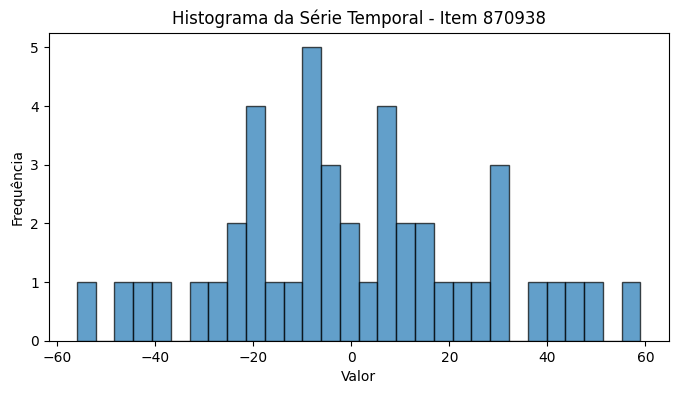

In [18]:
plt.figure(figsize=(8, 4))
plt.hist(residuos_item, bins=30, edgecolor='k', alpha=0.7)
plt.title('Histograma da Série Temporal - Item ' + str(item_nbr))
plt.xlabel('Valor')
plt.ylabel('Frequência')
plt.show()

In [19]:
# Realizar o teste de Shapiro-Wilk
stat, p = shapiro(residuos_item)

# Exibir a estatística de teste e o valor p
print("Estatística de Teste:", stat)
print("Valor p:", p)

if p < 0.05:
  print("A distribuição não é normal (rejeita-se a hipótese nula).")
else:
  print("A distribuição é normal (aceita-se a hipótese nula).")

Estatística de Teste: 0.9902910570794424
Valor p: 0.9693219104774069
A distribuição é normal (aceita-se a hipótese nula).


# Utilizando a biblioteca Lazypredict

In [20]:
# utilizando lazy prediction para escolher um modelo

from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split

X = df_agg.index
y = df_agg['unit_sales']

X = pd.DataFrame(X, columns=['index']) # Convert X to a DataFrame

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

clear_output()
models

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
LGBMRegressor,0.47,0.52,27748.31,0.02
HistGradientBoostingRegressor,0.46,0.51,28088.79,0.08
ElasticNet,0.40,0.45,29721.72,0.00
TweedieRegressor,0.38,0.44,29989.19,0.00
GammaRegressor,0.38,0.44,30081.66,0.01
AdaBoostRegressor,0.36,0.41,30693.35,0.02
HuberRegressor,0.34,0.40,30949.25,0.01
RANSACRegressor,0.33,0.39,31210.30,0.01
Ridge,0.20,0.27,34208.82,0.01


In [21]:
# Inicializar o LGBMRegressor
model = lgb.LGBMRegressor(
    n_estimators=100,       # Número de árvores
    learning_rate=0.1,      # Taxa de aprendizado
    max_depth=-1,           # Profundidade máxima das árvores (-1 significa sem limite)
    num_leaves=31,          # Número máximo de folhas em cada árvore
    random_state=42
)

# Treinar o modelo
model.fit(X_train, y_train)

# Fazer previsões
y_pred = model.predict(X_test)

# Avaliar o modelo
mse = mean_squared_error(y_test, y_pred)
clear_output()
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 784659202.4018416
